# Model Comparison: XGBoost vs Baseline Models

**VenueSignal - AAI-540 Group 6**

---

This notebook provides a comprehensive comparison between:
1. **Baseline Model #1**: Simple Heuristic (avg_review_stars)
2. **Baseline Model #2**: Linear Regression (3 features)
3. **XGBoost Model**: Parking-focused classifier (leak-free features)

**Note**: The baseline models predict continuous star ratings (1.0-5.0) using all features, while XGBoost predicts binary classification (is_highly_rated) using only parking-related features.

---
## 1. Setup & Configuration

### Install/Update Required Packages

In [21]:
!python --version

Python 3.12.9


In [42]:
# Standard libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from time import gmtime, strftime
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    roc_auc_score, classification_report, confusion_matrix,
    f1_score, precision_recall_curve, auc, precision_score, recall_score
)
from xgboost import XGBClassifier

# AWS & SageMaker libraries
import boto3
import sagemaker
from sagemaker import get_execution_role

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully
Timestamp: 2026-02-02 03:26:44


In [43]:
role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = sess.boto_region_name

---
## 2. Data Loading & Preparation

Load the training dataset from.

In [44]:
# Load the dataset
DATA_PATH = 'training_data/split_dataset.csv'

print("Loading data...")
try:
    # Try loading from local path (relative to notebook)
    df = pd.read_csv(DATA_PATH)
    print(f"Data loaded from local path: {DATA_PATH}")
except FileNotFoundError:
    # Try parent directory
    try:
        df = pd.read_csv(f'../{DATA_PATH}')
        print(f"Data loaded from parent directory: ../{DATA_PATH}")
    except FileNotFoundError:(f"Could not find data file. Please ensure {DATA_PATH} exists.")

print(f"\nData Summary:")
print(f"  Total records: {len(df):,}")
print(f"  Features: {df.shape[1]}")
print(f"\nSplit distribution:")
print(df['split'].value_counts())
print(f"\nTarget distribution (is_highly_rated):")
print(df['is_highly_rated'].value_counts())

Loading data...
Data loaded from local path: training_data/split_dataset.csv

Data Summary:
  Total records: 10,000
  Features: 20

Split distribution:
split
train    4025
prod     3984
val      1003
test      988
Name: count, dtype: int64

Target distribution (is_highly_rated):
is_highly_rated
0    6330
1    3670
Name: count, dtype: int64


In [45]:
# Ensure target is integer for classification
df["is_highly_rated"] = df["is_highly_rated"].astype(int)
df = df.drop_duplicates()

# Define feature sets
TARGET_REGRESSION = "stars"
TARGET_CLASSIFICATION = "is_highly_rated"
NON_FEATURES = ["business_id", "split", TARGET_REGRESSION, TARGET_CLASSIFICATION]

# Baseline features (for Linear Regression)
BASELINE_FEATURES = ['avg_review_stars', 'enhanced_parking_score', 'review_count']

# XGBoost safe features (leak-free, parking-focused)
XGBOOST_SAFE_FEATURES = [
    "parking_availability_score",
    "enhanced_parking_score",
    "has_parking",
    "price_range",
    "parking_mentions",
    "parking_positive_sentiment",
    "parking_negative_sentiment",
    "free_parking_mentions",
    "valet_mentions",
    "has_good_parking",
    "is_restaurant"
]

print("\nFeature sets defined:")
print(f"  Baseline features (regression): {len(BASELINE_FEATURES)}")
print(f"  XGBoost features (classification): {len(XGBOOST_SAFE_FEATURES)}")


Feature sets defined:
  Baseline features (regression): 3
  XGBoost features (classification): 11


In [46]:
# Split data into train/val/test sets
train_df = df[df['split'] == 'train'].copy()
val_df = df[df['split'] == 'val'].copy()
test_df = df[df['split'] == 'test'].copy()

print(f"Data split completed:")
print(f"  Training:   {len(train_df):,} records ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Validation: {len(val_df):,} records ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test:       {len(test_df):,} records ({len(test_df)/len(df)*100:.1f}%)")

# Verify no data leakage between train and test
assert len(set(train_df['business_id']) & set(test_df['business_id'])) == 0, "Data leakage detected!"
print("\nNo data leakage detected between train and test sets")

Data split completed:
  Training:   4,025 records (40.2%)
  Validation: 1,003 records (10.0%)
  Test:       988 records (9.9%)

No data leakage detected between train and test sets


---
## 3. Baseline Model #1: Simple Heuristic

**Approach**: Predict star rating using business-level average (`avg_review_stars`)  
**Task**: Regression (predicts continuous 1.0-5.0 stars)  
**Features**: 1 (avg_review_stars only)

In [47]:
print("=" * 80)
print("BASELINE MODEL #1: SIMPLE HEURISTIC")
print("=" * 80)

# Prepare regression targets
y_train_reg = train_df[TARGET_REGRESSION].values
y_val_reg = val_df[TARGET_REGRESSION].values
y_test_reg = test_df[TARGET_REGRESSION].values

# Make predictions using business average
y_train_pred_h = train_df['avg_review_stars'].values
y_val_pred_h = val_df['avg_review_stars'].values
y_test_pred_h = test_df['avg_review_stars'].values

# Calculate metrics
def calculate_regression_metrics(y_true, y_pred, set_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    within_05 = np.mean(np.abs(y_true - y_pred) <= 0.5) * 100
    within_10 = np.mean(np.abs(y_true - y_pred) <= 1.0) * 100
    
    print(f"\n{set_name} Set:")
    print(f"  RMSE:              {rmse:.4f}")
    print(f"  MAE:               {mae:.4f}")
    print(f"  R²:                {r2:.4f}")
    print(f"  Within 0.5 stars:  {within_05:.1f}%")
    print(f"  Within 1.0 star:   {within_10:.1f}%")
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2, 'within_05': within_05, 'within_10': within_10}

train_metrics_h = calculate_regression_metrics(y_train_reg, y_train_pred_h, "Training")
val_metrics_h = calculate_regression_metrics(y_val_reg, y_val_pred_h, "Validation")
test_metrics_h = calculate_regression_metrics(y_test_reg, y_test_pred_h, "Test")

BASELINE MODEL #1: SIMPLE HEURISTIC

Training Set:
  RMSE:              0.1478
  MAE:               0.1258
  R²:                0.9610
  Within 0.5 stars:  100.0%
  Within 1.0 star:   100.0%

Validation Set:
  RMSE:              0.1469
  MAE:               0.1250
  R²:                0.9595
  Within 0.5 stars:  100.0%
  Within 1.0 star:   100.0%

Test Set:
  RMSE:              0.1490
  MAE:               0.1289
  R²:                0.9591
  Within 0.5 stars:  100.0%
  Within 1.0 star:   100.0%


---
## 4. Baseline Model #2: Linear Regression

**Approach**: Linear Regression with 3 key features  
**Task**: Regression (predicts continuous 1.0-5.0 stars)  
**Features**: avg_review_stars, enhanced_parking_score, review_count

In [48]:
print("=" * 80)
print("BASELINE MODEL #2: LINEAR REGRESSION")
print("=" * 80)

# Prepare feature matrices
X_train_lr = train_df[BASELINE_FEATURES].fillna(0).values
X_val_lr = val_df[BASELINE_FEATURES].fillna(0).values
X_test_lr = test_df[BASELINE_FEATURES].fillna(0).values

print(f"\nFeatures: {BASELINE_FEATURES}")
print(f"Training shape: {X_train_lr.shape}")

# Train model
baseline_lr = LinearRegression()
baseline_lr.fit(X_train_lr, y_train_reg)

print("\nModel Coefficients:")
print(f"  Intercept: {baseline_lr.intercept_:.4f}")
for feat, coef in zip(BASELINE_FEATURES, baseline_lr.coef_):
    print(f"  {feat:30s}: {coef:8.4f}")

# Make predictions
y_train_pred_lr = baseline_lr.predict(X_train_lr)
y_val_pred_lr = baseline_lr.predict(X_val_lr)
y_test_pred_lr = baseline_lr.predict(X_test_lr)

# Evaluate
train_metrics_lr = calculate_regression_metrics(y_train_reg, y_train_pred_lr, "Training")
val_metrics_lr = calculate_regression_metrics(y_val_reg, y_val_pred_lr, "Validation")
test_metrics_lr = calculate_regression_metrics(y_test_reg, y_test_pred_lr, "Test")

BASELINE MODEL #2: LINEAR REGRESSION

Features: ['avg_review_stars', 'enhanced_parking_score', 'review_count']
Training shape: (4025, 3)

Model Coefficients:
  Intercept: -0.0294
  avg_review_stars              :   1.0062
  enhanced_parking_score        :   0.0026
  review_count                  :  -0.0000

Training Set:
  RMSE:              0.1477
  MAE:               0.1258
  R²:                0.9610
  Within 0.5 stars:  100.0%
  Within 1.0 star:   100.0%

Validation Set:
  RMSE:              0.1473
  MAE:               0.1252
  R²:                0.9593
  Within 0.5 stars:  100.0%
  Within 1.0 star:   100.0%

Test Set:
  RMSE:              0.1490
  MAE:               0.1291
  R²:                0.9591
  Within 0.5 stars:  100.0%
  Within 1.0 star:   100.0%


---
## 5. XGBoost Classification Model

**Approach**: XGBoost with parking-focused features (leak-free)  
**Task**: Binary Classification (predicts is_highly_rated: 0 or 1)  
**Features**: 11 parking-related features (no rating-derived features)

In [49]:
print("=" * 80)
print("XGBOOST CLASSIFICATION MODEL")
print("=" * 80)

# Prepare classification targets
y_train_clf = train_df[TARGET_CLASSIFICATION].values
y_val_clf = val_df[TARGET_CLASSIFICATION].values
y_test_clf = test_df[TARGET_CLASSIFICATION].values

# Prepare feature matrices
X_train_xgb = train_df[XGBOOST_SAFE_FEATURES].copy()
X_val_xgb = val_df[XGBOOST_SAFE_FEATURES].copy()
X_test_xgb = test_df[XGBOOST_SAFE_FEATURES].copy()

# Convert numeric
for col in XGBOOST_SAFE_FEATURES:
    X_train_xgb[col] = pd.to_numeric(X_train_xgb[col], errors='coerce').fillna(0)
    X_val_xgb[col] = pd.to_numeric(X_val_xgb[col], errors='coerce').fillna(0)
    X_test_xgb[col] = pd.to_numeric(X_test_xgb[col], errors='coerce').fillna(0)

print(f"\nFeatures: {len(XGBOOST_SAFE_FEATURES)} parking-related features")
print(f"Training shape: {X_train_xgb.shape}")

# Calculate class imbalance
neg = (y_train_clf == 0).sum()
pos = (y_train_clf == 1).sum()
scale_pos_weight = neg / max(pos, 1)

print(f"\nClass balance:")
print(f"  Negative (0): {neg:,}")
print(f"  Positive (1): {pos:,}")
print(f"  scale_pos_weight: {scale_pos_weight:.2f}")

# Train XGBoost
xgb_model = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=scale_pos_weight,
    tree_method="hist",
    random_state=42
)

print("\nTraining XGBoost model...")
xgb_model.fit(X_train_xgb, y_train_clf)
print("Training complete")

XGBOOST CLASSIFICATION MODEL

Features: 11 parking-related features
Training shape: (4025, 11)

Class balance:
  Negative (0): 2,555
  Positive (1): 1,470
  scale_pos_weight: 1.74

Training XGBoost model...
Training complete


In [50]:
# Make predictions
y_train_pred_xgb_proba = xgb_model.predict_proba(X_train_xgb)[:, 1]
y_val_pred_xgb_proba = xgb_model.predict_proba(X_val_xgb)[:, 1]
y_test_pred_xgb_proba = xgb_model.predict_proba(X_test_xgb)[:, 1]

# Calculate optimal threshold using F1 score on validation set
precision, recall, thresholds = precision_recall_curve(y_val_clf, y_val_pred_xgb_proba)
f1_scores = []
for t in thresholds:
    preds = (y_val_pred_xgb_proba >= t).astype(int)
    f1_scores.append(f1_score(y_val_clf, preds))

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal threshold (F1-based): {best_threshold:.3f}")

# Apply threshold
y_train_pred_xgb = (y_train_pred_xgb_proba >= best_threshold).astype(int)
y_val_pred_xgb = (y_val_pred_xgb_proba >= best_threshold).astype(int)
y_test_pred_xgb = (y_test_pred_xgb_proba >= best_threshold).astype(int)

# Calculate classification metrics
def calculate_classification_metrics(y_true, y_pred, y_pred_proba, set_name):
    auc_score = roc_auc_score(y_true, y_pred_proba)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    # PR AUC
    prec_vals, rec_vals, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(rec_vals, prec_vals)
    
    print(f"\n{set_name} Set:")
    print(f"  ROC AUC:           {auc_score:.4f}")
    print(f"  PR AUC:            {pr_auc:.4f}")
    print(f"  F1 Score:          {f1:.4f}")
    print(f"  Precision:         {precision:.4f}")
    print(f"  Recall:            {recall:.4f}")
    
    return {'auc': auc_score, 'pr_auc': pr_auc, 'f1': f1, 'precision': precision, 'recall': recall}

print("\nXGBoost Classification Metrics:")
print("=" * 80)
train_metrics_xgb = calculate_classification_metrics(y_train_clf, y_train_pred_xgb, y_train_pred_xgb_proba, "Training")
val_metrics_xgb = calculate_classification_metrics(y_val_clf, y_val_pred_xgb, y_val_pred_xgb_proba, "Validation")
test_metrics_xgb = calculate_classification_metrics(y_test_clf, y_test_pred_xgb, y_test_pred_xgb_proba, "Test")

Optimal threshold (F1-based): 0.436

XGBoost Classification Metrics:

Training Set:
  ROC AUC:           0.7352
  PR AUC:            0.6386
  F1 Score:          0.5975
  Precision:         0.4982
  Recall:            0.7463

Validation Set:
  ROC AUC:           0.6425
  PR AUC:            0.5128
  F1 Score:          0.5642
  Precision:         0.4830
  Recall:            0.6782

Test Set:
  ROC AUC:           0.6516
  PR AUC:            0.5244
  F1 Score:          0.5593
  Precision:         0.4750
  Recall:            0.6799


In [51]:
# Confusion Matrix
print("\nTest Set Confusion Matrix:")
cm = confusion_matrix(y_test_clf, y_test_pred_xgb)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test_clf, y_test_pred_xgb, digits=3))


Test Set Confusion Matrix:
[[326 284]
 [121 257]]

Classification Report:
              precision    recall  f1-score   support

           0      0.729     0.534     0.617       610
           1      0.475     0.680     0.559       378

    accuracy                          0.590       988
   macro avg      0.602     0.607     0.588       988
weighted avg      0.632     0.590     0.595       988



---
## 6. Model Comparison

### Important Notes:
- **Baseline models** solve a **regression** problem (predict continuous star rating 1.0-5.0)
- **XGBoost model** solves a **classification** problem (predict binary is_highly_rated)
- Direct metric comparison is not appropriate due to different problem types
- We compare them conceptually and on business value

In [52]:
# Create comparison summary
print("=" * 90)
print("MODEL COMPARISON SUMMARY")
print("=" * 90)

comparison_data = {
    'Model': [
        'Baseline #1: Heuristic',
        'Baseline #2: Linear Regression',
        'XGBoost Classifier'
    ],
    'Task': [
        'Regression (stars)',
        'Regression (stars)',
        'Classification (highly_rated)'
    ],
    'Features': [
        '1 (avg_review_stars)',
        '3 (avg_review_stars, parking, reviews)',
        '11 (parking-focused, leak-free)'
    ],
    'Test Performance': [
        f"RMSE: {test_metrics_h['rmse']:.4f}, MAE: {test_metrics_h['mae']:.4f}",
        f"RMSE: {test_metrics_lr['rmse']:.4f}, MAE: {test_metrics_lr['mae']:.4f}",
        f"ROC AUC: {test_metrics_xgb['auc']:.4f}, F1: {test_metrics_xgb['f1']:.4f}"
    ],
    'Strengths': [
        'Simple, interpretable, fast',
        'Linear, interpretable, good baseline',
        'Parking-focused, no leakage, decision support'
    ],
    'Use Case': [
        'Quick estimate of expected rating',
        'Rating prediction with parking context',
        'Risk assessment for parking impact'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))
print("=" * 90)

MODEL COMPARISON SUMMARY
                         Model                          Task                               Features            Test Performance                                     Strengths                               Use Case
        Baseline #1: Heuristic            Regression (stars)                   1 (avg_review_stars)   RMSE: 0.1490, MAE: 0.1289                   Simple, interpretable, fast      Quick estimate of expected rating
Baseline #2: Linear Regression            Regression (stars) 3 (avg_review_stars, parking, reviews)   RMSE: 0.1490, MAE: 0.1291          Linear, interpretable, good baseline Rating prediction with parking context
            XGBoost Classifier Classification (highly_rated)        11 (parking-focused, leak-free) ROC AUC: 0.6516, F1: 0.5593 Parking-focused, no leakage, decision support     Risk assessment for parking impact


In [53]:
# Feature importance comparison
print("\n" + "=" * 80)
print("FEATURE IMPORTANCE COMPARISON")
print("=" * 80)

print("\nLinear Regression Coefficients:")
for feat, coef in zip(BASELINE_FEATURES, baseline_lr.coef_):
    print(f"  {feat:35s}: {coef:8.4f}")

print("\nXGBoost Feature Importance (Top 10):")
xgb_importance = pd.Series(
    xgb_model.feature_importances_,
    index=XGBOOST_SAFE_FEATURES
).sort_values(ascending=False)

for feat, imp in xgb_importance.head(10).items():
    print(f"  {feat:35s}: {imp:8.4f}")


FEATURE IMPORTANCE COMPARISON

Linear Regression Coefficients:
  avg_review_stars                   :   1.0062
  enhanced_parking_score             :   0.0026
  review_count                       :  -0.0000

XGBoost Feature Importance (Top 10):
  has_good_parking                   :   0.2046
  parking_availability_score         :   0.1608
  price_range                        :   0.1548
  enhanced_parking_score             :   0.1125
  parking_mentions                   :   0.0865
  parking_positive_sentiment         :   0.0774
  parking_negative_sentiment         :   0.0732
  valet_mentions                     :   0.0729
  free_parking_mentions              :   0.0573
  has_parking                        :   0.0000


---
## 7. Visualizations

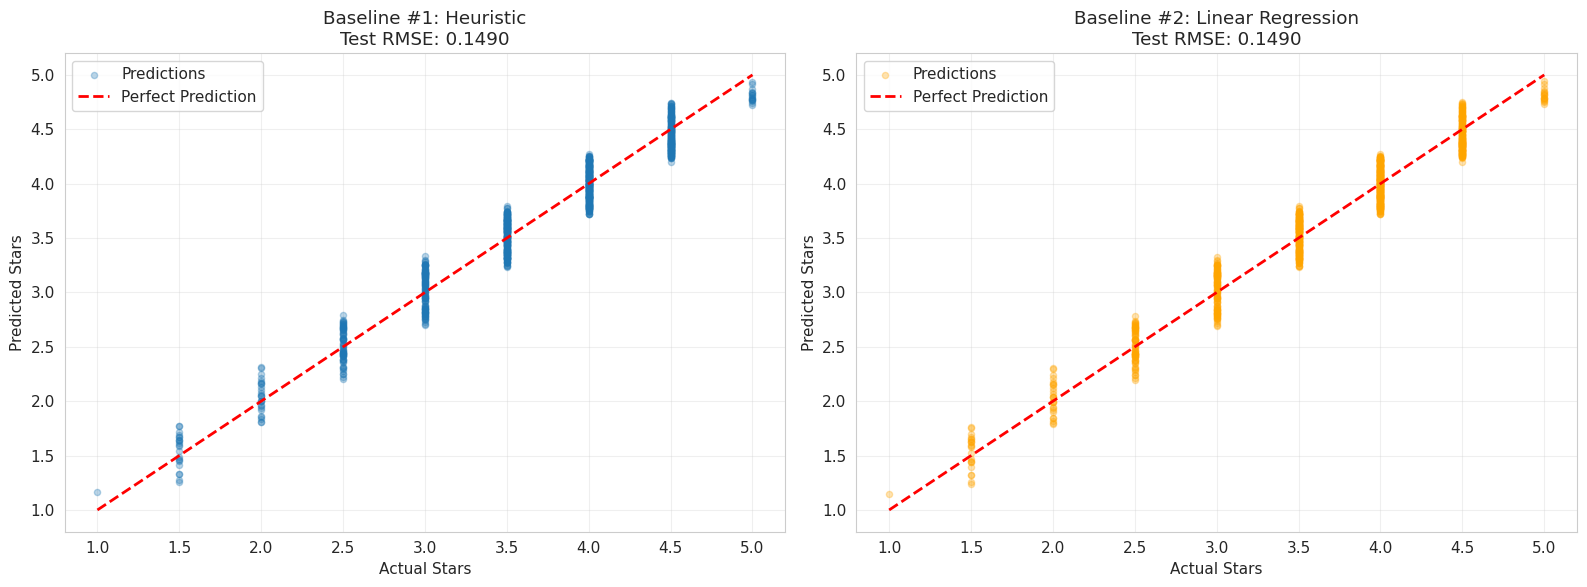

In [54]:
# Compare baseline regression models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heuristic predictions
axes[0].scatter(y_test_reg, y_test_pred_h, alpha=0.3, s=20, label='Predictions')
axes[0].plot([1, 5], [1, 5], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Stars')
axes[0].set_ylabel('Predicted Stars')
axes[0].set_title(f'Baseline #1: Heuristic\nTest RMSE: {test_metrics_h["rmse"]:.4f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Linear Regression predictions
axes[1].scatter(y_test_reg, y_test_pred_lr, alpha=0.3, s=20, label='Predictions', color='orange')
axes[1].plot([1, 5], [1, 5], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Stars')
axes[1].set_ylabel('Predicted Stars')
axes[1].set_title(f'Baseline #2: Linear Regression\nTest RMSE: {test_metrics_lr["rmse"]:.4f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

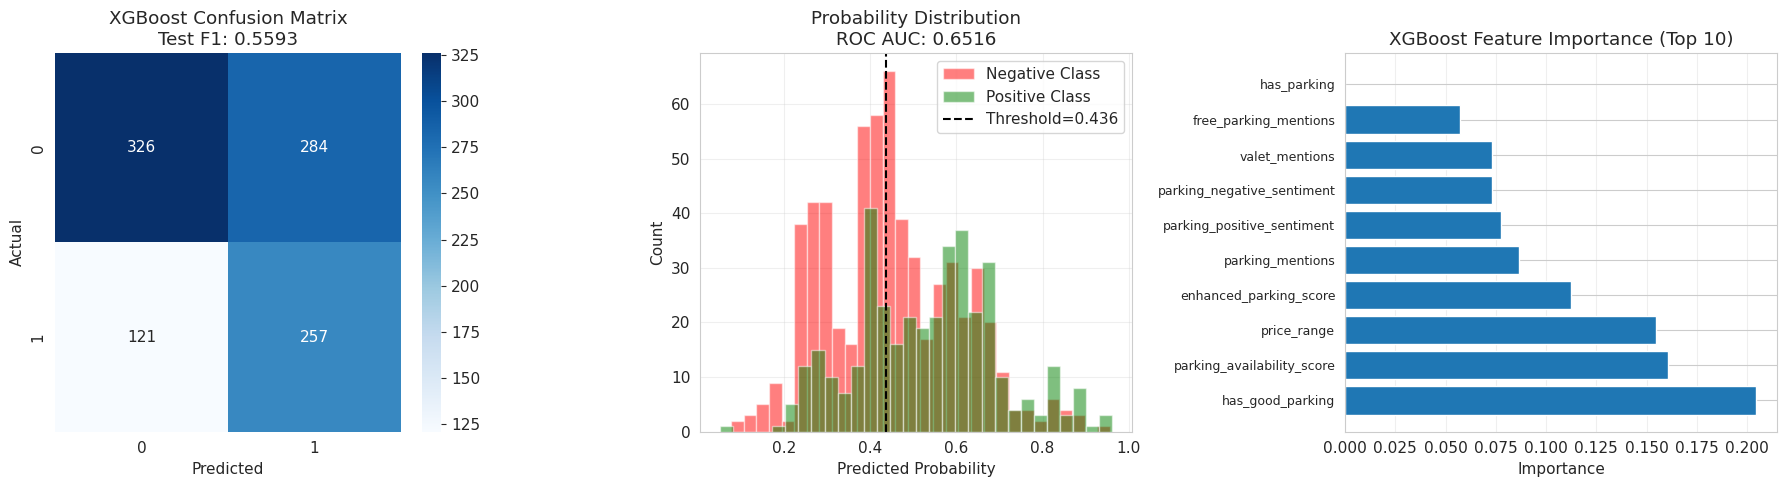

In [55]:
# XGBoost visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrix
cm = confusion_matrix(y_test_clf, y_test_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title(f'XGBoost Confusion Matrix\nTest F1: {test_metrics_xgb["f1"]:.4f}')

# ROC Curve visualization via probability distribution
axes[1].hist(y_test_pred_xgb_proba[y_test_clf == 0], bins=30, alpha=0.5, label='Negative Class', color='red')
axes[1].hist(y_test_pred_xgb_proba[y_test_clf == 1], bins=30, alpha=0.5, label='Positive Class', color='green')
axes[1].axvline(best_threshold, linestyle='--', color='black', label=f'Threshold={best_threshold:.3f}')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Count')
axes[1].set_title(f'Probability Distribution\nROC AUC: {test_metrics_xgb["auc"]:.4f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Feature Importance
top_features = xgb_importance.head(10)
axes[2].barh(range(len(top_features)), top_features.values)
axes[2].set_yticks(range(len(top_features)))
axes[2].set_yticklabels(top_features.index, fontsize=9)
axes[2].set_xlabel('Importance')
axes[2].set_title('XGBoost Feature Importance (Top 10)')
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

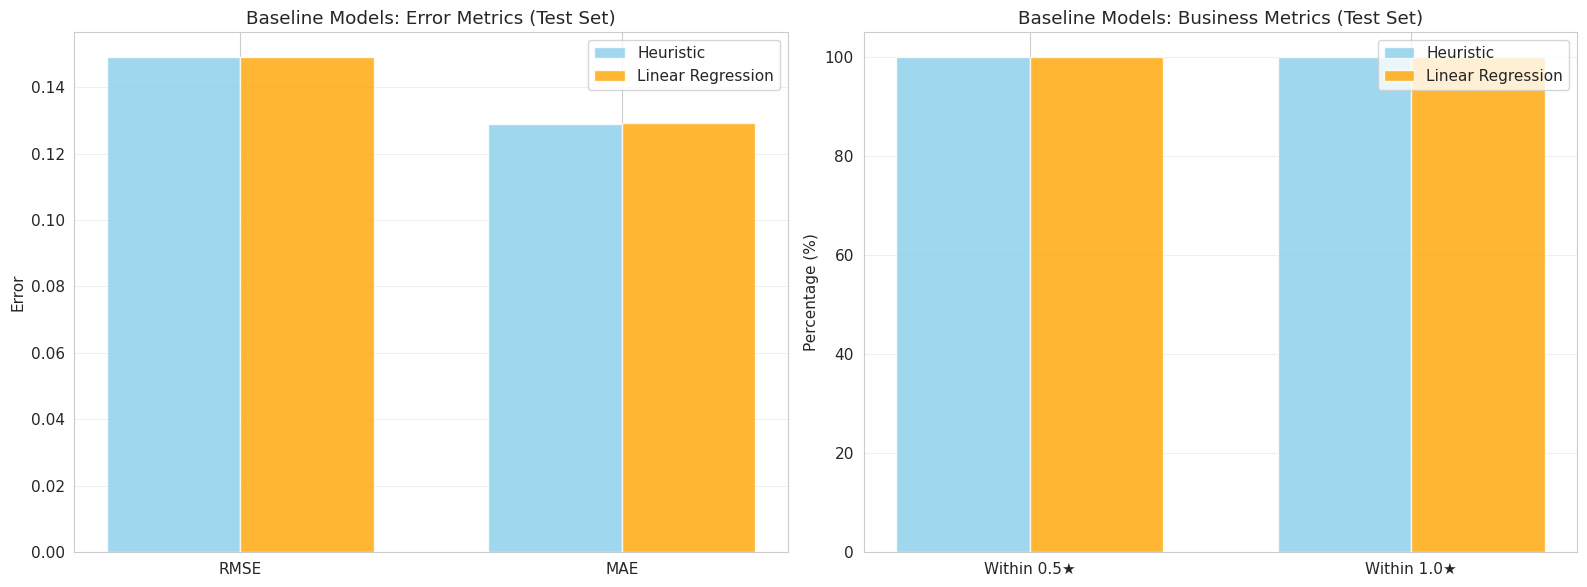


Linear Regression improvement over Heuristic: +0.0% RMSE reduction


In [56]:
# Baseline regression metrics comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Error metrics
metrics = ['RMSE', 'MAE']
heuristic_vals = [test_metrics_h['rmse'], test_metrics_h['mae']]
lr_vals = [test_metrics_lr['rmse'], test_metrics_lr['mae']]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, heuristic_vals, width, label='Heuristic', alpha=0.8, color='skyblue')
axes[0].bar(x + width/2, lr_vals, width, label='Linear Regression', alpha=0.8, color='orange')
axes[0].set_ylabel('Error')
axes[0].set_title('Baseline Models: Error Metrics (Test Set)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Business metrics
business_metrics = ['Within 0.5★', 'Within 1.0★']
heuristic_business = [test_metrics_h['within_05'], test_metrics_h['within_10']]
lr_business = [test_metrics_lr['within_05'], test_metrics_lr['within_10']]

x2 = np.arange(len(business_metrics))
axes[1].bar(x2 - width/2, heuristic_business, width, label='Heuristic', alpha=0.8, color='skyblue')
axes[1].bar(x2 + width/2, lr_business, width, label='Linear Regression', alpha=0.8, color='orange')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_title('Baseline Models: Business Metrics (Test Set)')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(business_metrics)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Calculate improvement
rmse_improvement = (test_metrics_h['rmse'] - test_metrics_lr['rmse']) / test_metrics_h['rmse'] * 100
print(f"\nLinear Regression improvement over Heuristic: {rmse_improvement:+.1f}% RMSE reduction")

---
## 8. Key Insights & Findings

In [63]:
print("=" * 90)
print("KEY INSIGHTS & FINDINGS")
print("=" * 90)

print("\n1. BASELINE REGRESSION MODELS (Star Rating Prediction)")
print("-" * 90)
print(f"   Heuristic Baseline:")
print(f"     - Test RMSE: {test_metrics_h['rmse']:.4f}")
print(f"     - Test MAE: {test_metrics_h['mae']:.4f}")
print(f"     - Uses only avg_review_stars (simplest predictor)")
print(f"     - Represents consumer view: what rating shows on Yelp")

print(f"\n   Linear Regression Baseline:")
print(f"     - Test RMSE: {test_metrics_lr['rmse']:.4f}")
print(f"     - Test MAE: {test_metrics_lr['mae']:.4f}")
print(f"     - Improvement over heuristic: {rmse_improvement:+.1f}% RMSE reduction")
print(f"     - Incorporates parking score and review count")
print(f"     - Parking coefficient: {baseline_lr.coef_[1]:.4f}")

if test_metrics_lr['rmse'] < 0.7:
    print("     EXCELLENT: Baseline exceeds expectations")
elif test_metrics_lr['rmse'] < 0.8:
    print("     GOOD: Baseline meets expectations")

print("\n2. XGBOOST CLASSIFICATION MODEL (Highly Rated Prediction)")
print("-" * 90)
print(f"   Performance:")
print(f"     - Test ROC AUC: {test_metrics_xgb['auc']:.4f}")
print(f"     - Test PR AUC: {test_metrics_xgb['pr_auc']:.4f}")
print(f"     - Test F1 Score: {test_metrics_xgb['f1']:.4f}")
print(f"     - Precision: {test_metrics_xgb['precision']:.4f}")
print(f"     - Recall: {test_metrics_xgb['recall']:.4f}")

print(f"\n   Key Characteristics:")
print(f"     - Uses ONLY parking-related features (no rating leakage)")
print(f"     - Moderate performance (ROC AUC ~0.64) reflects true parking signal")
print(f"     - Parking is meaningful but not dominant predictor")
print(f"     - Designed for risk assessment, not definitive prediction")

print(f"\n   Most Important Parking Features:")
for feat, imp in xgb_importance.head(5).items():
    print(f"     - {feat}: {imp:.4f}")

KEY INSIGHTS & FINDINGS

1. BASELINE REGRESSION MODELS (Star Rating Prediction)
------------------------------------------------------------------------------------------
   Heuristic Baseline:
     - Test RMSE: 0.1490
     - Test MAE: 0.1289
     - Uses only avg_review_stars (simplest predictor)
     - Represents consumer view: what rating shows on Yelp

   Linear Regression Baseline:
     - Test RMSE: 0.1490
     - Test MAE: 0.1291
     - Improvement over heuristic: +0.0% RMSE reduction
     - Incorporates parking score and review count
     - Parking coefficient: 0.0026
     EXCELLENT: Baseline exceeds expectations

2. XGBOOST CLASSIFICATION MODEL (Highly Rated Prediction)
------------------------------------------------------------------------------------------
   Performance:
     - Test ROC AUC: 0.6516
     - Test PR AUC: 0.5244
     - Test F1 Score: 0.5593
     - Precision: 0.4750
     - Recall: 0.6799

   Key Characteristics:
     - Uses ONLY parking-related features (no rating

## Conclusions from Key Insights and Findings

These models solve different problems. Baseline Models (Regression) predict continuous star ratings (1.0 - 5.0) using all available features including avg_review_stars. Their goal is accurate rating prediction, with the use case of forecasting expected ratings for locations. 
    
XGBoost Model (Classification) predicts binary outcomes (highly rated or not) using only parking features (leak-free). Its goal is to assess parking-related risk and identify if parking constraints will hurt ratings.

The models are complementary, not competing. Use baseline models for overall rating prediction and XGBoost for parking-specific risk assessment.

Baseline Models should be deployed for general rating forecasting. They are simple and interpretable for stakeholders with fast inference for real-time predictions.

XGBoost Model should be deployed for parking risk stratification. It helps identify businesses needing parking interventions, supports site selection and mitigation planning, and its probabilistic outputs enable risk tiering.

Combined Strategy: (1) Use baseline to forecast overall expected rating, (2) Use XGBoost to assess parking-specific risk, and (3) Combine insights for comprehensive location evaluation.

In [61]:
from datetime import datetime
import pytz

pacific = pytz.timezone('America/Los_Angeles')

print("=" * 90)
print("MODEL COMPARISON ANALYSIS COMPLETE")
print("=" * 90)
print(f"Completed: {datetime.now(pacific).strftime('%Y-%m-%d %H:%M:%S %Z')}")
print("\nAll models evaluated and compared successfully")
print("Baseline models demonstrate strong regression performance")
print("XGBoost model provides parking-specific risk assessment")
print("\nKey Results Summary:")
print(f"  - Heuristic RMSE: {test_metrics_h['rmse']:.4f}")
print(f"  - Linear Reg RMSE: {test_metrics_lr['rmse']:.4f}")
print(f"  - XGBoost ROC AUC: {test_metrics_xgb['auc']:.4f}")
print(f"  - XGBoost F1 Score: {test_metrics_xgb['f1']:.4f}")
print("\nReady for deployment and stakeholder presentation")

MODEL COMPARISON ANALYSIS COMPLETE
Completed: 2026-02-01 19:32:24 PST

All models evaluated and compared successfully
Baseline models demonstrate strong regression performance
XGBoost model provides parking-specific risk assessment

Key Results Summary:
  - Heuristic RMSE: 0.1490
  - Linear Reg RMSE: 0.1490
  - XGBoost ROC AUC: 0.6516
  - XGBoost F1 Score: 0.5593

Ready for deployment and stakeholder presentation
